In [1]:
import os
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import warnings
import shap 
import cleanlab

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from helpers import*

warnings.simplefilter("ignore")

c:\Users\Philippine\Documents\Job search\SDSC\flour-screening\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load processed data

In [2]:
df = pd.read_csv("data/flour-dataset-cleaned.csv").set_index('Package ID')
class_map = {'Low': 0, 'Average': 1, 'High': 2}
classes = ['Low', 'Average', 'High']

class_weights =  [1.2, 2.5, 5] #(df.shape[1] / df['Quality'].value_counts() * 10).to_numpy()
class_weights = {i : w for i, w in enumerate(class_weights)}

# Split data for training

We shall make sure that train - test split have the same label distribution as whole data set.

In [3]:
X_train, X_test, X_val, y_train, y_test, y_val, train_idx, test_idx, val_idx, features = prepare_dataset(df, val_size=0.2)

print(f"Check label distrib in train set : {y_train.value_counts() / y_train.shape[0]}")
print(f"Check label distrib in test set : {y_test.value_counts() / y_test.shape[0]}")
print(f"Check label distrib in test set : {y_val.value_counts() / y_val.shape[0]}")


Check label distrib in train set : Quality
1.0    0.609842
0.0    0.369947
2.0    0.020211
Name: count, dtype: float64
Check label distrib in test set : Quality
1.0    0.609551
0.0    0.370787
2.0    0.019663
Name: count, dtype: float64
Check label distrib in test set : Quality
1.0    0.610526
0.0    0.368421
2.0    0.021053
Name: count, dtype: float64


In [4]:
# Compute theoretical benefit if no errors
nb_labels = y_test.value_counts()
benefit = -len(y_test) + nb_labels[0] * class_weights[0] + nb_labels[1] * class_weights[1] + nb_labels[2] * class_weights[2]
print("Theoretical benefit: ", benefit)

Theoretical benefit:  379.9


In [5]:
# Compute weekly theoretical benefit
print("Weekly theoretical benefit: ", benefit * 1000 / len(y_test))

Weekly theoretical benefit:  1067.1348314606741


## Cleanlab test

In [5]:
import cleanlab

model_lg = LogisticRegression(multi_class='multinomial', random_state=42 ,penalty='l2', class_weight='balanced')

# CleanLearning: Machine Learning with cleaned data (given messy, real-world data)
cl = cleanlab.classification.CleanLearning(model_lg, seed=42)

# Fit model to messy, real-world data, automatically training on cleaned data.
_ = cl.fit(X_train.to_numpy(), y_train.astype(int))

# See the label quality for every example, which data has issues, and more.
res = cl.get_label_issues()
res['id'] = X_train.index.to_list()
res.loc[res['is_label_issue']]

,is_label_issue,label_quality,given_label,predicted_label,sample_weight,id
20,True,0.315043,1,0,0.0,461901
23,True,0.186616,0,1,0.0,687839
24,True,0.337710,1,0,0.0,892653
27,True,0.237873,1,0,0.0,147328
38,True,0.120122,0,1,0.0,592184
...,...,...,...,...,...,...
1107,True,0.133605,0,1,0.0,687839
1111,True,0.347783,0,1,0.0,910305
1112,True,0.133605,0,1,0.0,687839
1121,True,0.008051,1,0,0.0,573969


In [6]:
reg_fit = cl.fit(X_train.to_numpy(), y_train.astype(int), label_issues=res)

Total benefit 235.1000 CHF on 356 examples.
Balanced accuracy: 0.7255387981194433
Macro f1-score: 0.73677965227261
Macro precision: 0.7512074835703055
Macro recall: 0.7255387981194433
Kappa score: 0.6027355768464346
              precision    recall  f1-score   support

         Low       0.73      0.78      0.75       132
     Average       0.86      0.82      0.84       217
        High       0.67      0.57      0.62         7

    accuracy                           0.80       356
   macro avg       0.75      0.73      0.74       356
weighted avg       0.81      0.80      0.80       356



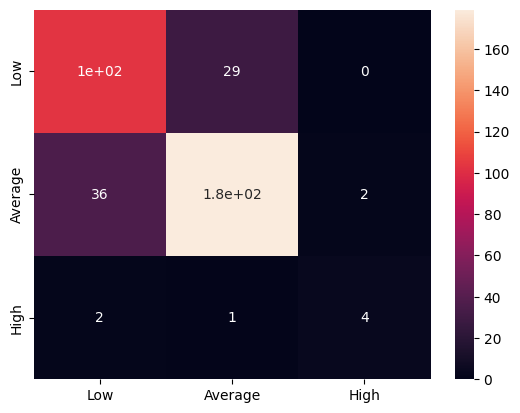

In [7]:
_ = evaluate(reg_fit, X_test, y_test, classes, test_idx)

In [8]:
res.loc[res['is_label_issue'] & (res['predicted_label'] == 2)]

,is_label_issue,label_quality,given_label,predicted_label,sample_weight,id
141,True,0.002482,0,2,0.0,313250
159,True,0.140469,1,2,0.0,394724
355,True,0.049372,0,2,0.0,427447
380,True,0.089330,1,2,0.0,553855
400,True,0.076971,0,2,0.0,362934
420,True,0.196567,0,2,0.0,593889
458,True,0.220200,1,2,0.0,769264
627,True,0.133994,0,2,0.0,200876
751,True,0.135367,1,2,0.0,693468
781,True,0.103867,0,2,0.0,215096


In [9]:
df_misc = df.loc[res['id']].reset_index()
df_misc = df_misc.merge(res[['id', 'predicted_label']], left_on='Package ID', right_on='id')

In [10]:
df_misc

,Package ID,Gluten Content (%),Dough Elasticity Index,Dampening Time (hours),Package Weight (g),Ash content (%),Moisture (%),Package Volume (cm3),Proteins (g)/100g,Quality,Production Mill_Ancient Oak Mill,Production Mill_Happy Blackberry Windmill,Production Mill_Redwood Orchard Watermill,Production Recipe_1.0,Production Recipe_2.0,Production Recipe_3.0,Production Recipe_4.0,Production Recipe_5.0,id,predicted_label
0,589667,-1.553615,0.889612,0.011727,0.082353,0.017623,-0.714678,-0.322825,-1.161071,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,589667,1
1,589667,-1.553615,0.889612,0.011727,0.082353,0.017623,-0.714678,-0.322825,-1.161071,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,589667,1
2,589667,-1.553615,0.889612,0.011727,0.082353,0.017623,-0.714678,-0.322825,-1.161071,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,589667,1
3,589667,-1.553615,0.889612,0.011727,0.082353,0.017623,-0.714678,-0.322825,-1.161071,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,589667,1
4,589667,-1.553615,0.889612,0.011727,0.082353,0.017623,-0.714678,-0.322825,-1.161071,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,589667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43327,727691,-0.005800,-0.714892,-0.315537,-0.583090,0.417856,1.551592,1.150626,0.490858,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,727691,0
43328,727691,-0.005800,-0.714892,-0.315537,-0.583090,0.417856,1.551592,1.150626,0.490858,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,727691,0
43329,727691,-0.005800,-0.714892,-0.315537,-0.583090,0.417856,1.551592,1.150626,0.490858,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,727691,0
43330,727691,-0.005800,-0.714892,-0.315537,-0.583090,0.417856,1.551592,1.150626,0.490858,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,727691,0


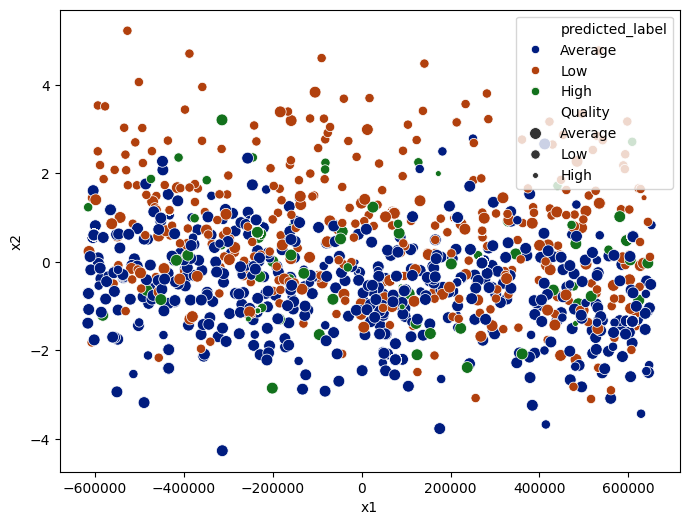

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_x = df_misc
x = df_x.drop(['Quality', 'predicted_label'], axis=1).to_numpy()
pca_res = pca.fit_transform(x)

df_plot = pd.DataFrame(pca_res, columns=['x1', 'x2'])
df_plot['predicted_label'] = df_x['predicted_label'].map({v : k for k, v in class_map.items()})
df_plot['Quality'] = df_x['Quality'].map({v : k for k, v in class_map.items()})

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_plot, x='x1', y='x2', hue='predicted_label', palette='dark', size='Quality')
plt.show()

# Training

In [7]:
from sklearn.metrics import precision_score, f1_score, balanced_accuracy_score, recall_score, make_scorer

custom_avg_p = make_scorer(precision_score, average='macro')
custom_w_f1 = make_scorer(f1_score, average='macro')
custom_w_acc = make_scorer(balanced_accuracy_score)
custom_w_recall = make_scorer(recall_score, average='macro')



## Train a Logistic regression classifier

In [8]:
X_train, X_test, X_val, y_train, y_test, y_val, train_idx, test_idx, val_idx, _ = prepare_dataset(df, val_size=0.2)

log_reg = LogisticRegression(random_state=42, class_weight=class_weights, penalty='l2')

param_grid = {
    'C' : np.logspace(-5,5,50)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring=custom_w_f1)

grid_search.fit(X_val, y_val)
print(f"Best params : {grid_search.best_params_} for best CV score : {grid_search.best_score_}")

Best params : {'C': 8.286427728546842} for best CV score : 0.7430575895447903


In [9]:
log_reg = LogisticRegression(random_state=42, C=grid_search.best_params_['C'], penalty='l2', class_weight=class_weights)
log_reg_fit = log_reg.fit(X_train, y_train)

In [30]:
log_reg_fit.predict_proba(X_test.sample(1))

array([[0.07779588, 0.91341425, 0.00878986]])

Total benefit 249.6000 CHF on 356 examples.
Balanced accuracy: 0.6183843038681748
Macro f1-score: 0.6803396281657151
Macro precision: 0.860335731414868
Macro recall: 0.6183843038681748
Kappa score: 0.4706225990900883
              precision    recall  f1-score   support

         Low       0.84      0.48      0.61       132
     Average       0.74      0.95      0.83       217
        High       1.00      0.43      0.60         7

    accuracy                           0.76       356
   macro avg       0.86      0.62      0.68       356
weighted avg       0.78      0.76      0.74       356



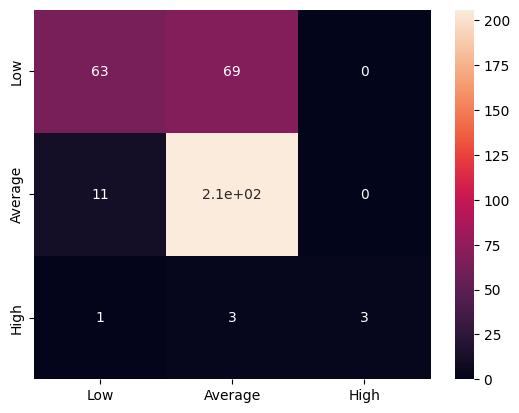

In [10]:
mis_1, benefit = evaluate(log_reg_fit, X_test, y_test, classes, test_idx)

In [11]:
print("Weekly benefit: ", 249.6 * 1000/356)

Weekly benefit:  701.123595505618


## Train a XGboost classifier

In [12]:
from xgboost import XGBClassifier

X_train, X_test, X_val, y_train, y_test, y_val, train_idx, test_idx, val_idx, _ = prepare_dataset(df, val_size=0.2)

xgboost = XGBClassifier( random_state=42)
sample_weights_val = y_val.astype(int).map(class_weights).to_numpy()
sample_weights_tr = y_train.astype(int).map(class_weights).to_numpy()

param_grid = {
    'n_estimators': [20, 50, 100, 150, 200, 250, 300],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgboost, param_grid, cv=cv, scoring=custom_w_f1)
grid_search.fit(X_val, y_val, sample_weight=sample_weights_val)

print(f"Best params : {grid_search.best_params_} : {grid_search.best_score_}")

Best params : {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 20} : 0.8156407278358498


In [13]:
# Train the model
best_params = grid_search.best_params_
xgboost_ft = XGBClassifier(random_state=42,\
                            max_depth = best_params['max_depth'],\
                            n_estimators=best_params['n_estimators'],\
                            min_child_weight=best_params['min_child_weight']).fit(X_train, y_train, sample_weight=sample_weights_tr)

Total benefit 285.6000 CHF on 356 examples.
Balanced accuracy: 0.6941418796257506
Macro f1-score: 0.7569438773195408
Macro precision: 0.9054531490015361
Macro recall: 0.6941418796257506
Kappa score: 0.6743847287386304
              precision    recall  f1-score   support

         Low       0.89      0.70      0.78       132
     Average       0.83      0.95      0.89       217
        High       1.00      0.43      0.60         7

    accuracy                           0.85       356
   macro avg       0.91      0.69      0.76       356
weighted avg       0.85      0.85      0.84       356



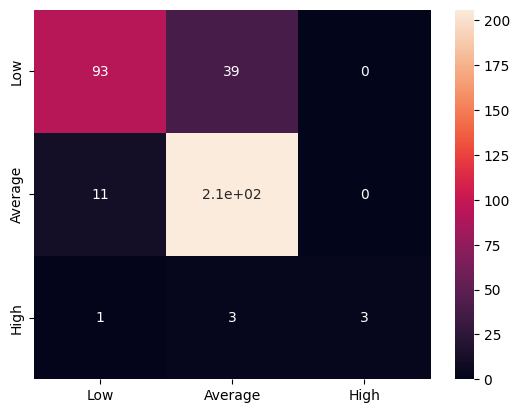

In [60]:
mis_2,_ = evaluate(xgboost_ft, X_test, y_test, classes, test_idx)

In [15]:
print("Weekly benefit: ", 285.6 * 1000/356)

Weekly benefit:  802.2471910112359


# Study predictions

## Logistic Regression 

In [16]:
explainer = shap.Explainer(log_reg_fit, X_train) 
shap_values = explainer(X_test)

Text(0.5, 1.0, 'Coefficient analysis for predicting Low Quality')

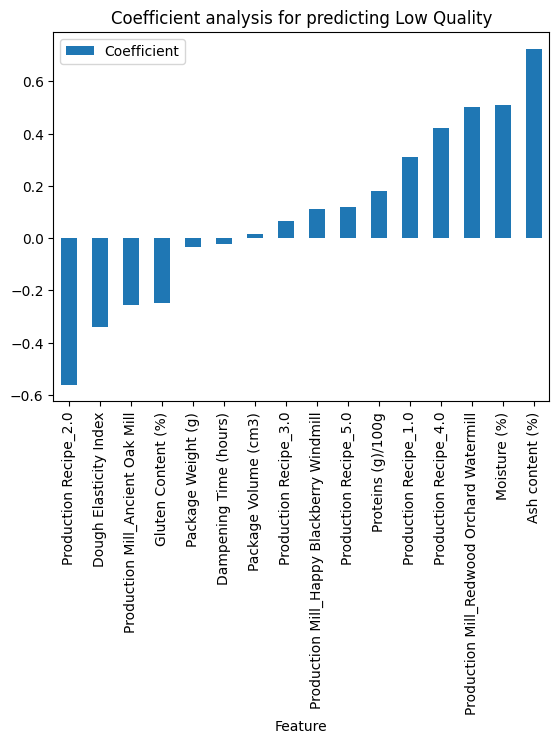

In [36]:
coefs = log_reg.coef_[0]
df_plot = pd.DataFrame({'Feature':X_train.columns, 'Coefficient': coefs}).sort_values(by='Coefficient')
df_plot.plot(kind='bar', x='Feature', y='Coefficient')
plt.title('Coefficient analysis for predicting Low Quality')

Text(0.5, 1.0, 'Coefficient analysis for predicting Average Quality')

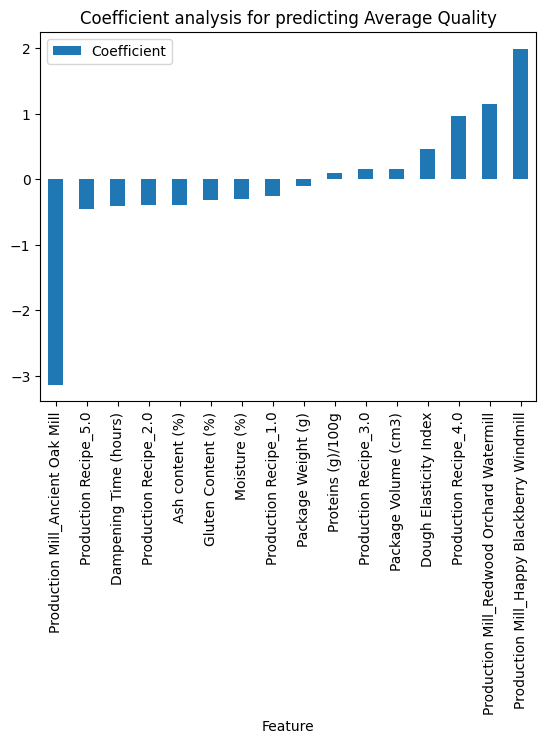

In [34]:
coefs = log_reg.coef_[1]
df_plot = pd.DataFrame({'Feature':X_train.columns, 'Coefficient': coefs}).sort_values(by='Coefficient')
df_plot.plot(kind='bar', x='Feature', y='Coefficient')
plt.title('Coefficient analysis for predicting Average Quality')

Text(0.5, 1.0, 'Coefficient analysis for predicting High Quality')

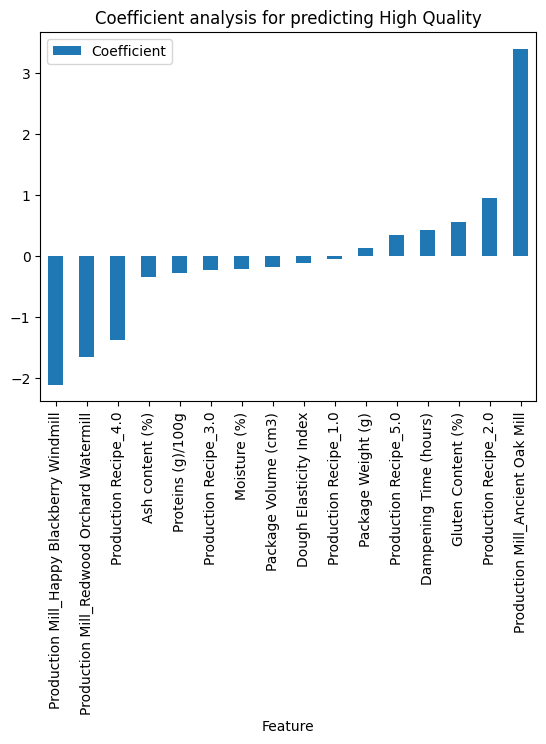

In [33]:
coefs = log_reg.coef_[2]
df_plot = pd.DataFrame({'Feature':X_train.columns, 'Coefficient': coefs}).sort_values(by='Coefficient')
df_plot.plot(kind='bar', x='Feature', y='Coefficient')
plt.title('Coefficient analysis for predicting High Quality')

Feature Importance (SHAP values):


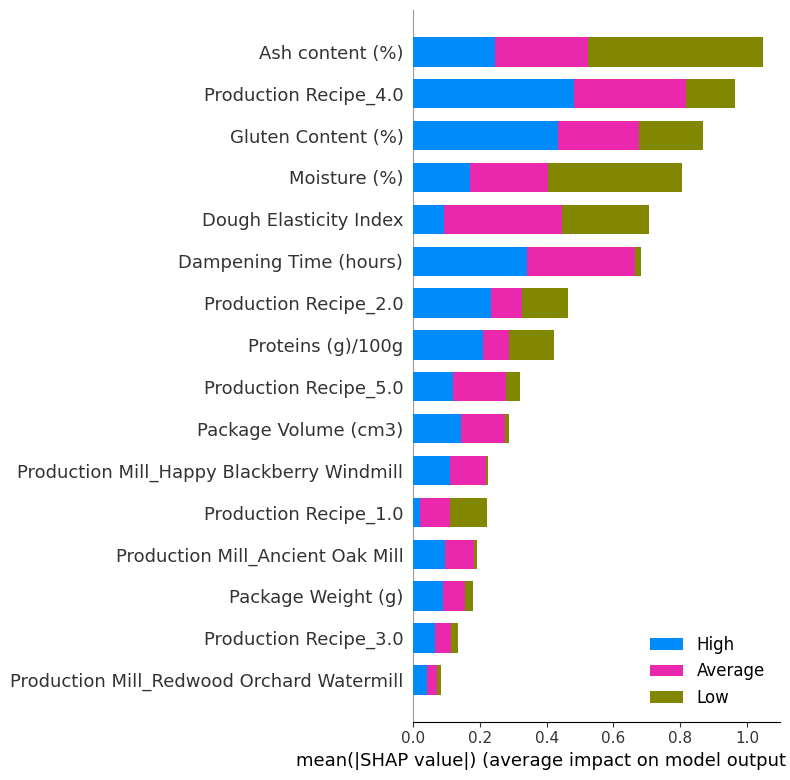

In [18]:
print("Feature Importance (SHAP values):")
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, class_names=classes)

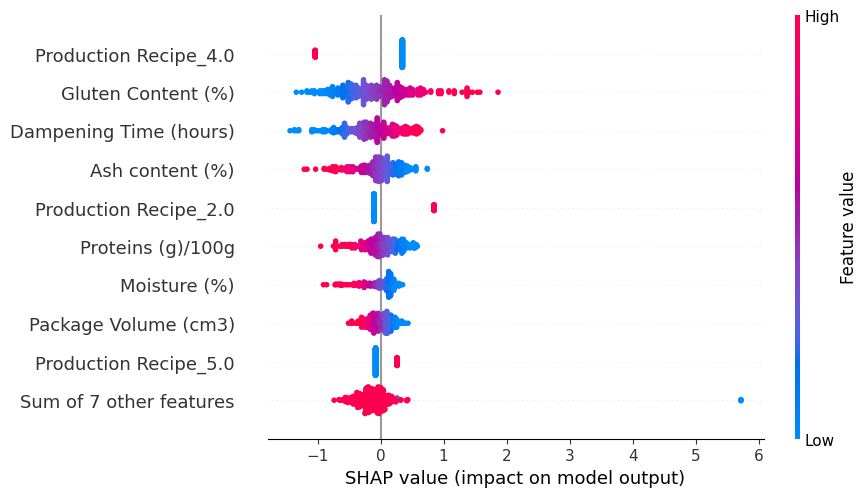

In [19]:
shap.plots.beeswarm(shap_values[:,:,2])

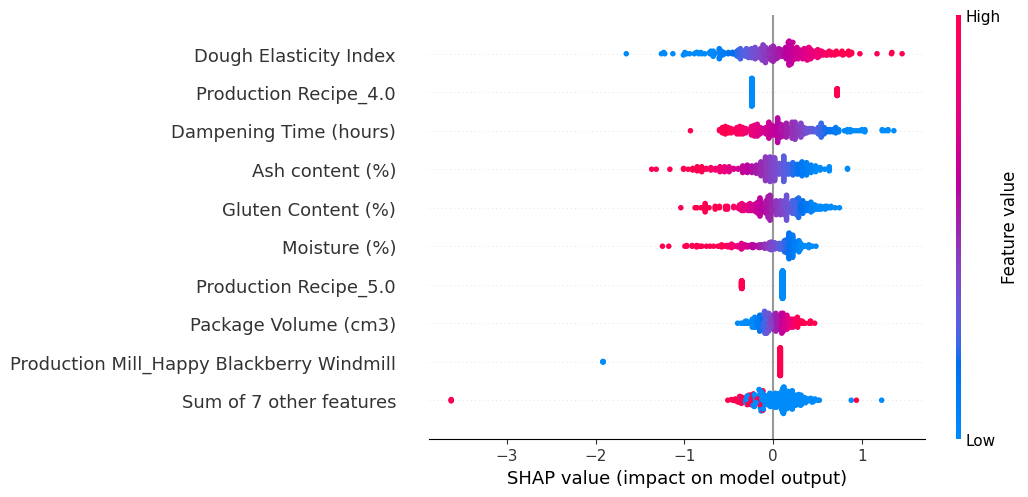

In [20]:
shap.plots.beeswarm(shap_values[:,:,1])

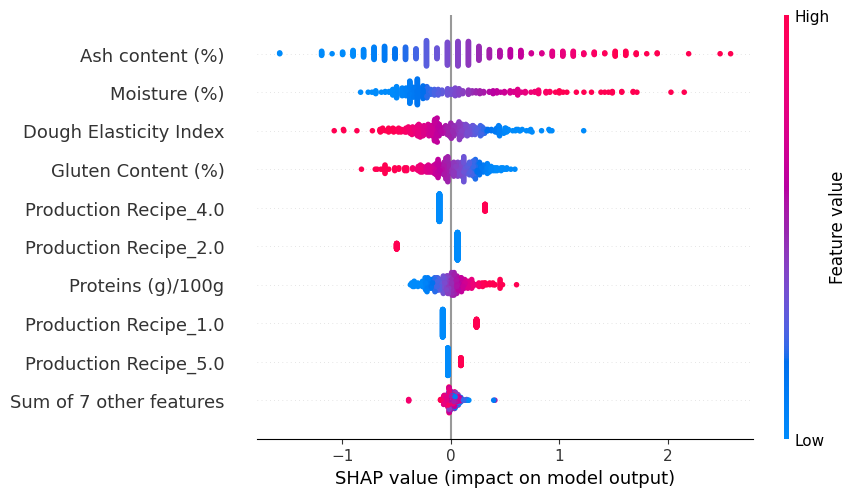

In [21]:
shap.plots.beeswarm(shap_values[:,:,0])

## Xgboost

In [37]:
explainer = shap.Explainer(xgboost_ft, X_train.sample(100)) 
shap_values = explainer(X_test)

Feature Importance (SHAP values):


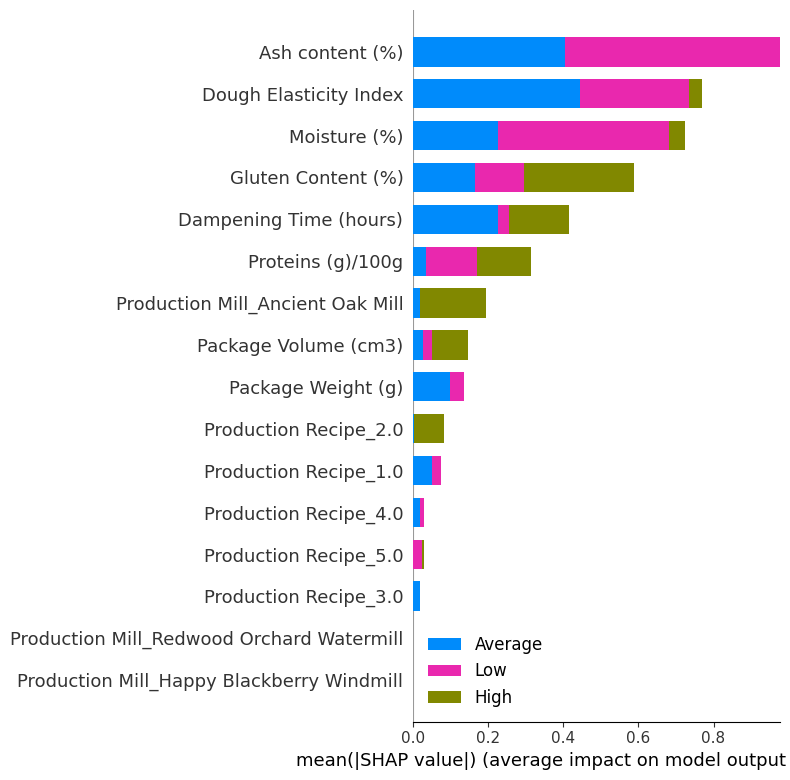

In [38]:
print("Feature Importance (SHAP values):")
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, class_names=classes)

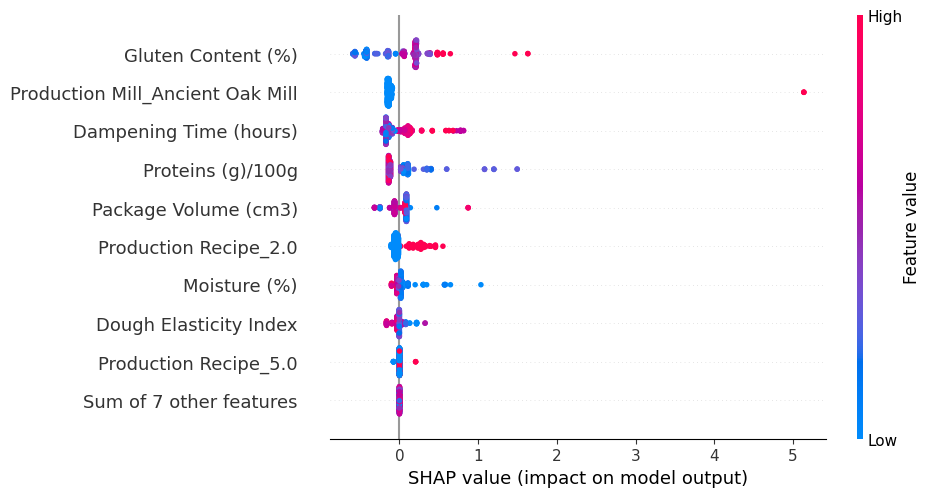

In [39]:
shap.plots.beeswarm(shap_values[:,:,2])

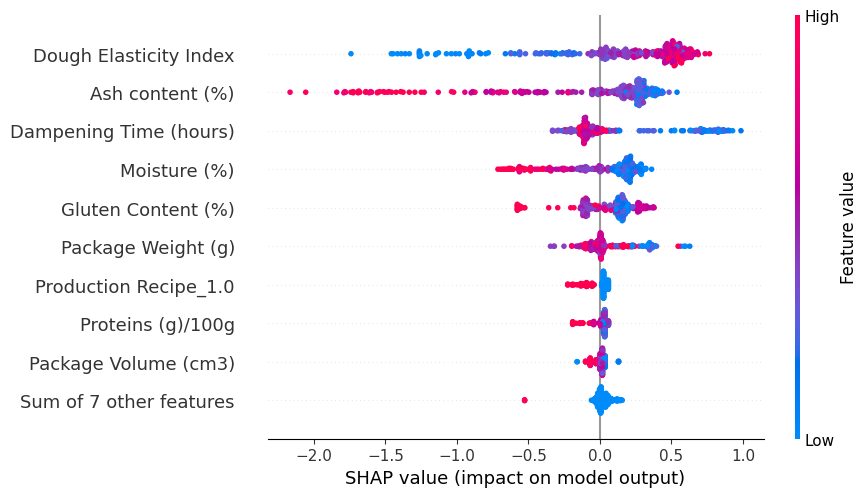

In [41]:
shap.plots.beeswarm(shap_values[:,:,1])

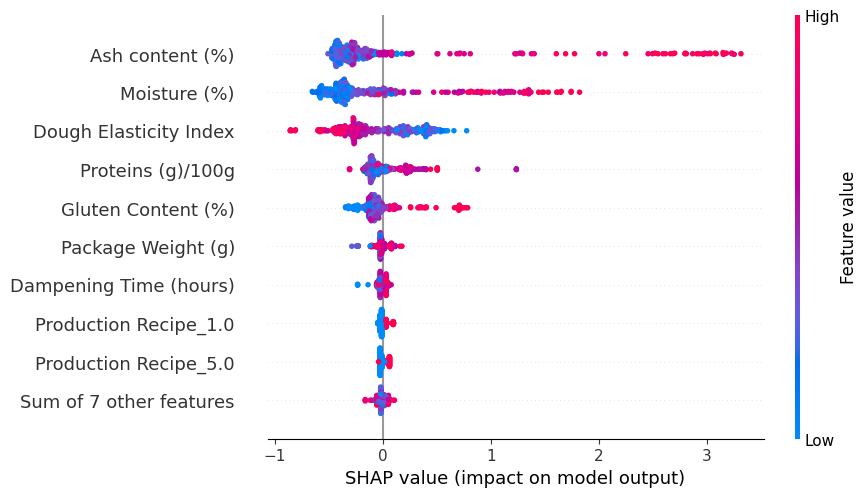

In [42]:
shap.plots.beeswarm(shap_values[:,:,0])

Text(0.5, 1.0, 'Xgboost features importance')

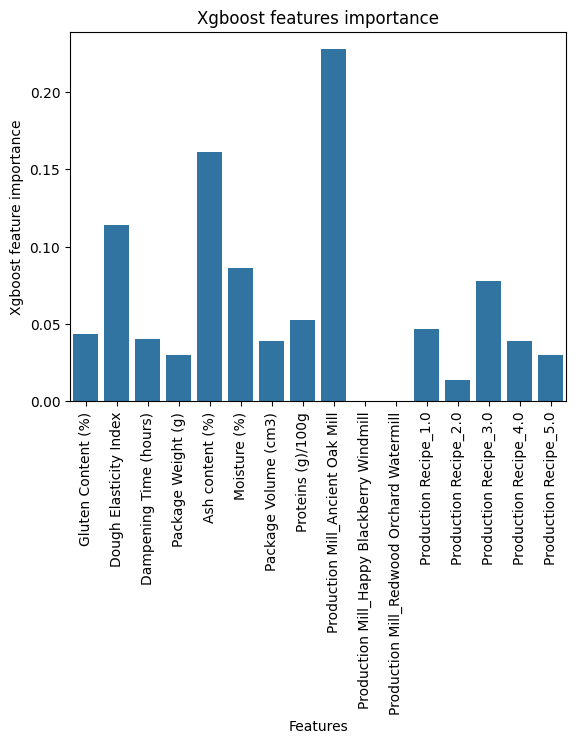

In [52]:
sns.barplot(x=X_test.columns, y=xgboost_ft.feature_importances_,)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel("Xgboost feature importance")
plt.title("Xgboost features importance")

# Study misclassified samples

In [62]:
intersec = set(mis_1).intersection(set(mis_2))
print(f"There are {len(intersec)} misclassified samples between the three classifiers, which represents {len(intersec) / len(y_test) * 100}% of total test data")

There are 42 misclassified samples between the three classifiers, which represents 11.797752808988763% of total test data
